# PEAD - stock market response to events

PEAD: Post/Pre Earning Announcement Drift 



## 0. Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import streamlit as st

from collections import defaultdict, Counter

In [2]:
import FinanceDataReader as fdr
import quantstats as qs

In [3]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

## 1. Import datasets

### Transaction volume & adjusted close data

- Import price-volume data module from KRX using custom lib `korquanttools`
- Import related datasets

In [4]:
# Global parameters

START = 20140101
END = 20220520

In [5]:
# Init data module
pricevolume = KRXPriceDM(START, END)
pricevolume.get_info()


        * DM name: KRX_pricevolume
        * DM description: Basic price-volume data imported from KRX website & NAVER finance. Has KOSPI, KOSDAQ, KONEX stocks.
        * birthday: 20211203
        * DM period: 19990101 ~ 
        * Available data: ['lv1', 'open', 'high', 'low', 'close', 'volume', 'dollarvolume', 'marketcap']
        


In [6]:
dollarvolume_df = pricevolume.get_data('dollarvolume')
dollarvolume_df = dollarvolume_df.astype(float)

In [7]:
holidays = dollarvolume_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

In [8]:
adjClose_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjClose_{START}_{END}")
return_df = pd.read_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")

### Earnings calendar data

- Import earnings calendar data scraped from investing.com
    - Check data count / unique company count
    - Currently, only small part of calendar data is scraped

In [9]:
earnings_calendar_df = pd.read_pickle('earnings_calendar_20140101-20220530.pickle')

In [10]:
len(earnings_calendar_df)

46300

In [11]:
len(earnings_calendar_df['sid'].unique())

2456

## 2. Event analysis 

- Process earnings calendar data to lv2 format
- Mix earnings calendar data & dependent variable (dollarvolume, adj.close, etc...) to plot event response graph
    - Normalize response data (dollarvolume, adj.close, etc) by company because they vary a lot between one another. 


In [20]:
earnings_calendar_df.drop_duplicates(subset=['date', 'sid'])

,date,EPS,EPS_forecast,revenue,revenue_forecast,codename,sid,is_announced
0,2014-01-16,NaN,972.88,NaN,9.403600e+11,KT&G Corp,033780,True
1,2014-01-20,-37.00,NaN,NaN,6.091100e+11,Hotel Shilla,008770,True
2,2014-01-21,NaN,1224.00,NaN,4.110000e+12,Hyundai Engineering & Const,000720,True
3,2014-01-21,NaN,NaN,NaN,3.064000e+11,Lotte Fine Chemical,004000,True
4,2014-01-21,NaN,932.50,NaN,NaN,Korea Line,005880,True
...,...,...,...,...,...,...,...,...
46295,2022-05-27,26.20,NaN,4.856000e+10,NaN,Cu Tech,376290,True
46296,2022-05-27,0.60,NaN,2.174000e+08,NaN,Wing Yip Food,900340,True
46297,2022-05-27,-0.03,NaN,2.671000e+07,NaN,Rothwell,900260,True
46298,2022-05-27,40.76,NaN,8.570000e+09,NaN,Pro2000,321260,True


In [21]:
# Make calendar event df 
# 1: event day 0: nothing OR does not exist
earnings_calendar_df['is_announced'] = True
earnings_calendar_df.drop_duplicates(inplace=True)

# TODO: Still, one sid making announcement on the very same day exists. 
earnings_calendar_df.drop_duplicates(subset=['date', 'sid'], inplace=True)

earnings_announcement_df = earnings_calendar_df.pivot(index='date', columns='sid', values='is_announced')
earnings_announcement_df = earnings_announcement_df.fillna(False)
earnings_announcement_df = earnings_announcement_df.reindex(index=dollarvolume_df.index, columns=dollarvolume_df.columns)

# Only use tradingdays data
dollarvolume_tradingdays_df = dollarvolume_df.loc[tradingdays, :]
earnings_announcement_tradingdays_df = earnings_announcement_df.loc[tradingdays, :]

### Normalization

In [22]:
NORMAL_WINDOW = 252 # Trading days in a year

In [23]:
dv_movingavg_tradingdays_df = dollarvolume_tradingdays_df.rolling(NORMAL_WINDOW).mean()
dv_movingstd_tradingdays_df = dollarvolume_tradingdays_df.rolling(NORMAL_WINDOW).std()

dv_stdnormal_tradingdays_df = (dollarvolume_tradingdays_df - dv_movingavg_tradingdays_df) / dv_movingstd_tradingdays_df

In [24]:
dv_stdnormal_tradingdays_df = dv_stdnormal_tradingdays_df.iloc[NORMAL_WINDOW:]
earnings_announcement_tradingdays_df = earnings_announcement_tradingdays_df.iloc[NORMAL_WINDOW:]

### Get near-event period response data

In [25]:
# Return dolloarvolume data back-and-forth for each event day.
# (5 days backward) _ _ _ _ _ EventDay _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ (20 days forward) 
# D-5 dollarvolume data       D-0                                    D+20 dollarvolume data

def event_by_sid(dollarvolume_df, earnings_announcement_df, d_minus=5, d_plus=20):
    assert dollarvolume_df.shape == earnings_announcement_df.shape
    assert (dollarvolume_df.index == earnings_announcement_df.index).all()
    assert (dollarvolume_df.columns == earnings_announcement_df.columns).all()

    sid_list = dollarvolume_df.columns
    date_list = np.array(dollarvolume_df.index)

    dollarvolume_2d = np.array(dollarvolume_df)
    event_2d = np.array(earnings_announcement_df)
    event_2d = np.where(event_2d == True, event_2d, False)
    
    dollarvolume_data = []
    for col_idx in range(event_2d.shape[1]):
        sid = sid_list[col_idx]

        dollar_col = dollarvolume_2d[:, col_idx]
        col = event_2d[:, col_idx]
        event_indices = np.where(col == True)[0]
        dates = date_list[event_indices]

        for event_idx, date in zip(event_indices, dates):
            start_idx = event_idx - d_minus
            if start_idx < 0:
                start_idx = 0
            
            end_idx = event_idx + d_plus
            if end_idx > len(col):
                end_idx = len(col) - 1
            
            event_period_data = dollar_col[start_idx:end_idx]
            dollarvolume_data.append({
                'sid': sid,
                'd_zero_date': date,
                'data': event_period_data, # TODO: Somewhere, data is becoming object!! 
            })
    
    return dollarvolume_data

In [26]:
dollarvolume_data = event_by_sid(dv_stdnormal_tradingdays_df, earnings_announcement_tradingdays_df)

In [27]:
dv_exploded_df = pd.DataFrame(dollarvolume_data).explode('data')
dv_exploded_df.reset_index(inplace=True, drop=True)
dv_exploded_df['data'] = dv_exploded_df['data'].astype(float) # TODO: Somewhere before data has become object!!

In [28]:
dv_exploded_df['d_date_num'] = dv_exploded_df.groupby(['sid', 'd_zero_date']).cumcount()
dv_final_event_period_data = dv_exploded_df.groupby('d_date_num').mean()['data']

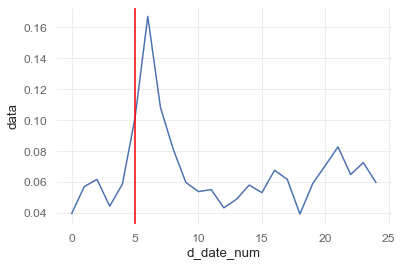

In [29]:
sns.lineplot(x=dv_final_event_period_data.index, y=dv_final_event_period_data)
plt.axvline(x=5, ymin=0, ymax=1, color='red')

## 3. Expansion - adj.close / return

In [30]:
NORMAL_WINDOW = 60 # 3 months = 1 quarter

In [31]:
# Only use tradingdays data
adjClose_tradingdays_df = adjClose_df.loc[tradingdays, :]
return_tradingdays_df = return_df.loc[tradingdays, :]


In [32]:
# adj Close
adjClose_movingavg_tradingdays_df = adjClose_tradingdays_df.rolling(NORMAL_WINDOW).mean()
adjClose_movingstd_tradingdays_df = adjClose_tradingdays_df.rolling(NORMAL_WINDOW).std()

adjClose_stdnormal_tradingdays_df = (adjClose_tradingdays_df - adjClose_movingavg_tradingdays_df) / adjClose_movingstd_tradingdays_df

# return
# return DOES NOT need normalization

In [33]:
adjClose_stdnormal_tradingdays_df = adjClose_stdnormal_tradingdays_df.iloc[NORMAL_WINDOW:]
return_tradingdays_df = return_tradingdays_df.iloc[NORMAL_WINDOW:]

earnings_announcement_tradingdays_df = earnings_announcement_df.loc[tradingdays, :]
earnings_announcement_tradingdays_df = earnings_announcement_tradingdays_df.iloc[NORMAL_WINDOW:]

In [34]:
adjClose_data = event_by_sid(adjClose_stdnormal_tradingdays_df, earnings_announcement_tradingdays_df)
return_data = event_by_sid(return_tradingdays_df, earnings_announcement_tradingdays_df)

In [35]:
adjClose_exploded_df = pd.DataFrame(adjClose_data).explode('data')
adjClose_exploded_df.reset_index(inplace=True, drop=True)
adjClose_exploded_df['data'] = adjClose_exploded_df['data'].astype(float) # TODO: Somewhere before data has become object!!

return_exploded_df = pd.DataFrame(return_data).explode('data')
return_exploded_df.reset_index(inplace=True, drop=True)
return_exploded_df['data'] = return_exploded_df['data'].astype(float) # TODO: Somewhere before data has become object!!

In [36]:
adjClose_exploded_df['d_date_num'] = adjClose_exploded_df.groupby(['sid', 'd_zero_date']).cumcount()
adjClose_final_event_period_data = adjClose_exploded_df.groupby('d_date_num').mean()['data']

return_exploded_df['d_date_num'] = return_exploded_df.groupby(['sid', 'd_zero_date']).cumcount()
return_final_event_period_data = return_exploded_df.groupby('d_date_num').mean()['data']

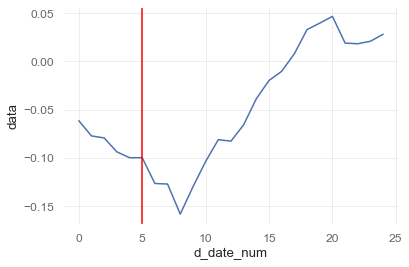

In [37]:
sns.lineplot(x=adjClose_final_event_period_data.index, y=adjClose_final_event_period_data)
plt.axvline(x=5, ymin=0, ymax=1, color='red')

We can observe that adj.Close declines after the event day

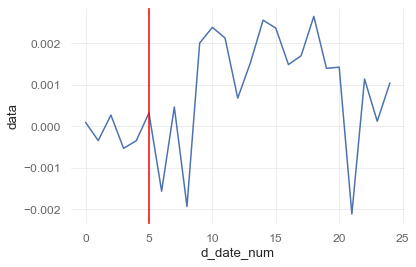

In [38]:
sns.lineplot(x=return_final_event_period_data.index, y=return_final_event_period_data)
plt.axvline(x=5, ymin=0, ymax=1, color='red')

# 4. Is there information leakage before announcement?

So far we have seen pre/post annoucnement change of dollarvolume, price, return. 

Now I will combine all these to test the hypothesis that there is information leakage in Korean stock market. 

The intuition is as follow:

- When we look at the dollarvolume change before the annoucement, we can see that there's a small drift before the announcement. 
- This could be due to many reasons like:
    - Risk-taking trades before the announcement. 
    - Information leakage before the announcement. 
        - i.e, insiders who already know the actual earning is higher/lower can make trades before the announcement to get near-risk-free return. 
- We can make a hypothesis out of this
    - If the insider knows that the earning is actual > forecast, he will buy(long) stocks. 
    - If the insider knows that the earning is actual < forecast, he will sell(short) stocks. 
- If the stock with information leakage is small capped and if the insider makes big enough trades to move the price:
    - Stock price will go up before actual > forecast is annoucned. 
    - Stock price will go down before actual < forecast is annoucned.
- Therefore, I will look at the "hit ratio" of cummulative return before the announcement to earnings announcement directions. 
    - If price goes up (= positive cumulative return) right before the announcement & earning is actual > forecast = HIT
    - If price goes down (= negative cumulative return) right before the announcement & earning is actual < forecast = MISS
- "Hit ratio" of each stock will be calculated. 
    - The data is 2014 ~ 2022 so 8y * 4q = 32 announcements per stock
    - If a certain stock has abnormally high "hit ratio", that stock is suspected of having information leakage. 
    

## 4-1 First, calculate pre-announcement cummulative return

This can be done by modifying already existing function just a little. 

In [39]:
# Return dolloarvolume data back-and-forth for each event day.
# (5 days backward) _ _ _ _ _ EventDay _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ (20 days forward) 
# D-5 dollarvolume data       D-0                                    D+20 dollarvolume data

def preannc_event_by_sid(return_df, earnings_announcement_df, d_minus=5, d_plus=20, preannc_days=None):
    assert return_df.shape == earnings_announcement_df.shape
    assert (return_df.index == earnings_announcement_df.index).all()
    assert (return_df.columns == earnings_announcement_df.columns).all()

    if preannc_days is None:
        preannc_days = d_minus - 1

    sid_list = return_df.columns
    date_list = np.array(return_df.index)

    return_2d = np.array(return_df).astype(float)
    event_2d = np.array(earnings_announcement_df)
    event_2d = np.where(event_2d == True, event_2d, False)
    
    return_data = []
    for col_idx in range(event_2d.shape[1]):
        sid = sid_list[col_idx]

        dollar_col = return_2d[:, col_idx]
        col = event_2d[:, col_idx]
        event_indices = np.where(col == True)[0]
        dates = date_list[event_indices]

        for event_idx, date in zip(event_indices, dates):
            start_idx = event_idx - d_minus
            if start_idx < 0:
                start_idx = 0
            
            end_idx = event_idx + d_plus
            if end_idx > len(col):
                end_idx = len(col) - 1
            
            event_period_data = dollar_col[start_idx:end_idx]
            preannc_cumreturn = event_period_data[:preannc_days].sum()

            return_data.append({
                'sid': sid,
                'd_zero_date': date,
                'data': event_period_data, # TODO: Somewhere, data is becoming object!! 
                'preannc': preannc_cumreturn,
            })
    
    return return_data

In [40]:
# Only use tradingdays data
return_tradingdays_df = return_df.loc[tradingdays, :]
earnings_announcement_tradingdays_df = earnings_announcement_df.loc[tradingdays, :]

In [41]:
return_data = preannc_event_by_sid(return_tradingdays_df, earnings_announcement_tradingdays_df)

In [42]:
return_exploded_df = pd.DataFrame(return_data).explode('data')
return_exploded_df.reset_index(inplace=True, drop=True)
return_exploded_df['data'] = return_exploded_df['data'].astype(float) # TODO: Somewhere before data has become object!!

In [43]:
return_exploded_df['d_date_num'] = return_exploded_df.groupby(['sid', 'd_zero_date']).cumcount()

In [44]:
return_exploded_df['is_positive_preannc'] = (return_exploded_df['preannc'] >= 0)

In [45]:
return_exploded_df.dropna(inplace=True)

## 4-2. Check "hit" companies

- If companies have positive cummulate return before the announcement, check if they have positive return on D-0 OR D+1
- If companies have negative cummulate return before the announcement, check if they have negative return on D-0 OR D+1

In [46]:
len(return_exploded_df[return_exploded_df['is_positive_preannc'] == True])

538503

In [47]:
len(return_exploded_df[return_exploded_df['is_positive_preannc'] != True])

553714

In [48]:
positive_bet = return_exploded_df[
    (return_exploded_df['d_date_num'].isin([5, 6])) & # D-0 or D+1 
    (return_exploded_df['data'] > 0) & # D-0 return OR D+1 return
    (return_exploded_df['is_positive_preannc'] == True) # pre-announcment cummulative return is positive
]
positive_bet

,sid,d_zero_date,data,preannc,d_date_num,is_positive_preannc
6,000020,2017-04-06,0.018418,0.012466,6,True
105,000020,2018-04-05,0.004082,0.063844,5,True
230,000020,2019-08-13,0.026906,0.118802,5,True
231,000020,2019-08-13,0.026201,0.118802,6,True
255,000020,2020-03-27,0.038983,0.126406,5,True
...,...,...,...,...,...,...
1105431,365900,2022-03-22,0.013393,0.031705,5,True
1105728,146320,2022-05-16,0.009479,0.023574,6,True
1105879,376930,2022-03-22,0.017173,0.023061,5,True
1106067,413630,2022-05-06,0.002299,0.000037,5,True


In [49]:
D0D1_both_hit = 5 + 6

In [50]:

companies_D0D1_pos_hit = positive_bet.groupby(['sid', 'd_zero_date'])['d_date_num'].sum()
companies_D0D1_pos_hit = companies_D0D1_pos_hit[companies_D0D1_pos_hit == D0D1_both_hit]
companies_D0D1_pos_hit = list(companies_D0D1_pos_hit.index)
companies_D0D1_pos_hit = [sid for sid, _ in companies_D0D1_pos_hit]

len(companies_D0D1_pos_hit)

4103

In [51]:
negative_bet = return_exploded_df[
    (return_exploded_df['d_date_num'].isin([5, 6])) &
    (return_exploded_df['data'] < 0) &
    (return_exploded_df['is_positive_preannc'] == False) 
]
negative_bet

,sid,d_zero_date,data,preannc,d_date_num,is_positive_preannc
30,000020,2017-07-05,-0.010676,-0.005712,5,False
56,000020,2017-11-29,-0.041860,-0.022076,6,False
81,000020,2018-03-30,-0.016327,-0.052795,6,False
131,000020,2018-08-14,-0.061947,-0.012875,6,False
155,000020,2018-11-28,-0.011665,-0.010411,5,False
...,...,...,...,...,...,...
1106157,388050,2022-05-16,-0.005764,-0.105808,5,False
1106166,405640,2022-05-16,-0.002283,-0.004540,5,False
1106175,413600,2022-05-11,-0.022430,-0.012552,5,False
1106176,413600,2022-05-11,-0.034417,-0.012552,6,False


In [52]:

companies_D0D1_neg_hit = negative_bet.groupby(['sid', 'd_zero_date'])['d_date_num'].sum()
companies_D0D1_neg_hit = companies_D0D1_neg_hit[companies_D0D1_neg_hit == D0D1_both_hit]
companies_D0D1_neg_hit = list(companies_D0D1_neg_hit.index)
companies_D0D1_neg_hit = [sid for sid, _ in companies_D0D1_neg_hit]

len(companies_D0D1_neg_hit)

5341

In [53]:
companies_hit_count = defaultdict(lambda: [0, 0])

for sid in companies_D0D1_pos_hit:
    companies_hit_count[sid][0] += 1

for sid in companies_D0D1_neg_hit:
    companies_hit_count[sid][1] += 1

In [54]:
unique_events = return_exploded_df[['sid', 'd_zero_date']].drop_duplicates()
event_counter = Counter(unique_events['sid'])

In [55]:
companies_hit_infos = []

for sid, (pos_hit, neg_hit) in companies_hit_count.items():
    total_hit = pos_hit + neg_hit
    total_count = event_counter[sid]
    
    if total_count == 0:
        continue
    
    hit_ratio = total_hit / total_count

    companies_hit_infos.append({
        'sid': sid,
        'pos_hit': pos_hit, 
        'neg_hit': neg_hit, 
        'total_hit': total_hit, 
        'total_count': total_count, 
        'hit_ratio':hit_ratio ,
    })

In [60]:
companies_hit_infos_df = pd.DataFrame(companies_hit_infos)
companies_hit_infos_df = companies_hit_infos_df.sort_values(by='hit_ratio', ascending=False)

In [68]:
companies_hit_infos_df[companies_hit_infos_df['total_count'] >= 10]

,sid,pos_hit,neg_hit,total_hit,total_count,hit_ratio
208,004365,5,2,7,11,0.636364
1836,338100,4,2,6,10,0.600000
1804,311690,2,4,6,10,0.600000
1190,086790,13,6,19,34,0.558824
682,033290,6,4,10,19,0.526316
...,...,...,...,...,...,...
2094,106080,0,1,1,21,0.047619
1984,038290,0,1,1,21,0.047619
2125,149950,0,1,1,22,0.045455
258,005440,1,0,1,27,0.037037


<AxesSubplot:>

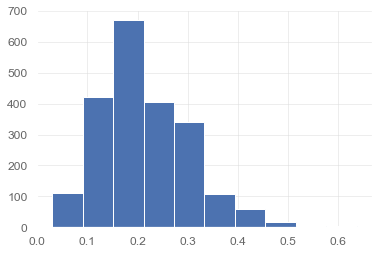

In [70]:
companies_hit_infos_df[companies_hit_infos_df['total_count'] >= 10]['hit_ratio'].hist()